In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import IPython.display as ipd
import librosa
import librosa.display

In [3]:
#### Extracting MFCC's For every audio file
import pandas as pd
import os
audio_dataset_path = 'Dataset25/'
metadata=pd.read_csv('Dataset25/chord_metadata.csv', encoding='latin-1')
metadata.head(10)

,filename,class,class_id
0,A (2).wav,A,0
1,A (3).wav,A,0
2,A (4).wav,A,0
3,A (5).wav,A,0
4,A (6).wav,A,0
5,A (7).wav,A,0
6,A (8).wav,A,0
7,A (9).wav,A,0
8,A (10).wav,A,0
9,A (11).wav,A,0


In [4]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [5]:
import numpy as np
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),str(row["class"]), str(row["filename"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

17629it [06:42, 34.85it/s]C:\Users\msi\anaconda3\envs\yolov4-gpu\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
63749it [25:12, 42.14it/s]


In [6]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-226.62538, 155.14899, -12.193161, 24.57414, ...",A
1,"[-283.57782, 175.26479, -17.304039, 18.349512,...",A
2,"[-256.9038, 150.7816, -3.8070192, 10.22072, 0....",A
3,"[-249.2126, 170.74902, -5.1216016, 10.584855, ...",A
4,"[-286.1759, 160.72075, 2.958544, 22.562437, -1...",A


In [7]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [8]:
X.shape

(63749, 40)

In [9]:
y

array(['A', 'A', 'A', ..., 'Gm', 'Gm', 'Gm'], dtype='<U15')

In [10]:
#label encoding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [11]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [12]:
y.shape

(63749, 25)

In [13]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [14]:
X_train


array([[-4.63197357e+02,  1.34707581e+02,  8.68994808e+00, ...,
         4.38757324e+00, -2.36326504e+00, -1.16418886e+01],
       [-3.03641235e+02,  1.36584686e+02, -1.23469152e+01, ...,
         6.37259817e+00,  2.75270104e+00,  2.93642342e-01],
       [-4.57863007e+02,  1.11551765e+02,  4.57621622e+00, ...,
        -1.56371319e+00,  3.88341689e+00, -7.89621305e+00],
       ...,
       [-3.98615601e+02,  1.45724915e+02,  4.85784531e+01, ...,
        -3.92145300e+00, -2.94256616e+00,  6.13953829e-01],
       [-3.09833221e+02,  5.47068634e+01, -6.88191376e+01, ...,
         2.68547535e+00, -1.70042908e+00,  4.30860233e+00],
       [-2.60631378e+02,  1.09430779e+02, -9.90855312e+00, ...,
        -4.82861662e+00, -7.51206064e+00, -5.20188332e-01]], dtype=float32)

In [15]:
X_train.shape

(50999, 40)

In [16]:
y_train.shape

(50999, 25)

In [17]:
X_test.shape

(12750, 40)

In [18]:
y_test.shape

(12750, 25)

Model Creation

In [19]:
import tensorflow as tf
print(tf.__version__)

2.9.0


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [21]:
### No of classes
num_labels=y.shape[1]

In [22]:
num_labels

25

In [23]:
model = Sequential([
    Dense(512, input_shape=(40,), activation="relu"),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_labels, activation='softmax')
]);

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               20992     
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 64)                8

In [25]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))


In [26]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_model/chord_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history= model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
1585/1594 [============================>.] - ETA: 0s - loss: 2.7561 - accuracy: 0.2295
Epoch 1: val_loss improved from inf to 0.81978, saving model to saved_model\chord_classification.hdf5
1594/1594 [==============================] - 9s 4ms/step - loss: 2.7484 - accuracy: 0.2314 - val_loss: 0.8198 - val_accuracy: 0.7944
Epoch 2/100
1582/1594 [============================>.] - ETA: 0s - loss: 0.8776 - accuracy: 0.7315
Epoch 2: val_loss improved from 0.81978 to 0.35507, saving model to saved_model\chord_classification.hdf5
1594/1594 [==============================] - 7s 5ms/step - loss: 0.8762 - accuracy: 0.7318 - val_loss: 0.3551 - val_accuracy: 0.8936
Epoch 3/100
1593/1594 [============================>.] - ETA: 0s - loss: 0.5534 - accuracy: 0.8324
Epoch 3: val_loss improved from 0.35507 to 0.34120, saving model to saved_model\chord_classification.hdf5
1594/1594 [==============================] - 6s 4ms/step - loss: 0.5535 - accuracy: 0.8324 - val_loss: 0.3412 - val_accurac

1594/1594 [==============================] - 8s 5ms/step - loss: 0.1148 - accuracy: 0.9640 - val_loss: 0.1359 - val_accuracy: 0.9577
Epoch 27/100
1584/1594 [============================>.] - ETA: 0s - loss: 0.1075 - accuracy: 0.9654
Epoch 27: val_loss did not improve from 0.13595
1594/1594 [==============================] - 8s 5ms/step - loss: 0.1076 - accuracy: 0.9654 - val_loss: 0.1375 - val_accuracy: 0.9594
Epoch 28/100
1589/1594 [============================>.] - ETA: 0s - loss: 0.1038 - accuracy: 0.9667
Epoch 28: val_loss did not improve from 0.13595
1594/1594 [==============================] - 8s 5ms/step - loss: 0.1038 - accuracy: 0.9667 - val_loss: 0.1415 - val_accuracy: 0.9569
Epoch 29/100
1590/1594 [============================>.] - ETA: 0s - loss: 0.1024 - accuracy: 0.9670
Epoch 29: val_loss did not improve from 0.13595
1594/1594 [==============================] - 8s 5ms/step - loss: 0.1023 - accuracy: 0.9670 - val_loss: 0.1393 - val_accuracy: 0.9582
Epoch 30/100
1586/1594 [

1581/1594 [============================>.] - ETA: 0s - loss: 0.0375 - accuracy: 0.9876
Epoch 55: val_loss did not improve from 0.12911
1594/1594 [==============================] - 8s 5ms/step - loss: 0.0374 - accuracy: 0.9876 - val_loss: 0.1593 - val_accuracy: 0.9642
Epoch 56/100
1581/1594 [============================>.] - ETA: 0s - loss: 0.0373 - accuracy: 0.9872
Epoch 56: val_loss did not improve from 0.12911
1594/1594 [==============================] - 7s 4ms/step - loss: 0.0372 - accuracy: 0.9872 - val_loss: 0.1669 - val_accuracy: 0.9646
Epoch 57/100
1587/1594 [============================>.] - ETA: 0s - loss: 0.0377 - accuracy: 0.9882
Epoch 57: val_loss did not improve from 0.12911
1594/1594 [==============================] - 7s 4ms/step - loss: 0.0377 - accuracy: 0.9882 - val_loss: 0.1795 - val_accuracy: 0.9613
Epoch 58/100
1582/1594 [============================>.] - ETA: 0s - loss: 0.0391 - accuracy: 0.9873
Epoch 58: val_loss did not improve from 0.12911
1594/1594 [===========

1588/1594 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 0.9935
Epoch 84: val_loss did not improve from 0.12911
1594/1594 [==============================] - 7s 4ms/step - loss: 0.0201 - accuracy: 0.9935 - val_loss: 0.1806 - val_accuracy: 0.9636
Epoch 85/100
1582/1594 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9937
Epoch 85: val_loss did not improve from 0.12911
1594/1594 [==============================] - 7s 4ms/step - loss: 0.0204 - accuracy: 0.9936 - val_loss: 0.1834 - val_accuracy: 0.9645
Epoch 86/100
1593/1594 [============================>.] - ETA: 0s - loss: 0.0221 - accuracy: 0.9930
Epoch 86: val_loss did not improve from 0.12911
1594/1594 [==============================] - 7s 4ms/step - loss: 0.0221 - accuracy: 0.9930 - val_loss: 0.1825 - val_accuracy: 0.9640
Epoch 87/100
1591/1594 [============================>.] - ETA: 0s - loss: 0.0207 - accuracy: 0.9936
Epoch 87: val_loss did not improve from 0.12911
1594/1594 [===========

Text(0.5, 0, 'epochs')

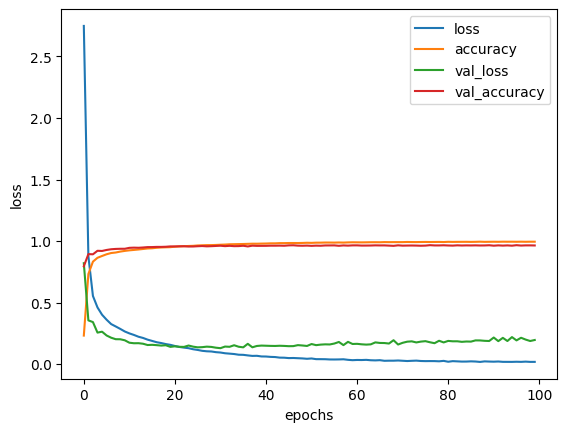

In [27]:
#plot history
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [28]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,2.748368,0.231416,0.819779,0.794353
1,0.876197,0.731838,0.355067,0.893569
2,0.553455,0.832369,0.341200,0.892157
3,0.460389,0.863723,0.255745,0.920706
4,0.401013,0.878488,0.263047,0.919294
...,...,...,...,...
95,0.018836,0.994020,0.192366,0.966274
96,0.017881,0.994627,0.213792,0.963137
97,0.019828,0.993941,0.199032,0.964627
98,0.017689,0.994549,0.187423,0.964627


In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

In [ ]:
filename="input/Chord Sample Guitar String.wav"
prediction_feature =  features_extractor(filename)
prediction_feature = prediction_feature.reshape(1,-1)
predict_x=model.predict(prediction_feature)
classes_x=np.argmax(predict_x,axis=1)
classes_x


prediction

In [ ]:
filename="input/Chord Sample Guitar String.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
prediction=model.predict(mfccs_scaled_features)
predicted_label = np.argmax(prediction, axis=1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

In [ ]:
from tensorflow.keras.models import load_model

loadmodel=load_model('saved_model13/chord_classification13.hdf5')

In [ ]:
import numpy as np

In [ ]:
filename="input/Gm.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
prediction=loadmodel.predict(mfccs_scaled_features)
predicted_label = np.argmax(prediction, axis=1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class